# Frontal Detection Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cf_xarray 

In [2]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

### Start with CESM historical simulation, 2000-2005

In [3]:
onehot_file = "cesm_frontsOneHot_2000-2005.nc"

In [4]:
onehot = xr.open_dataset(cesm_fronts_filepath+onehot_file)

In [5]:
fronts = onehot.fronts

Extract most likely front from onehot (via argmax)

In [6]:
%%time
allfronts = fronts.argmax(dim='front')

CPU times: user 9.96 s, sys: 26.4 s, total: 36.3 s
Wall time: 2min 10s


In [55]:
allfronts

<xarray.DataArray 'fronts' (time: 17520, lat: 68, lon: 141)>
array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]]])
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0

### Read in precipitation field

In [11]:
cesm_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [12]:
# h4.PRECT is 3hrly instantaneous
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)
PRECT_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"

preprocessing function to return PRECT only over North American domain

In [46]:
def preprocess(ds):
    #return ds['PRECT']
    return ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329))

read in PRECT files with preprocessing function

In [65]:
%%time
PRECT = xr.open_mfdataset(cesm_filepath+PRECT_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
#PRECT = xr.open_mfdataset(cesm_filepath+PRECT_files, concat_dim='time', combine="nested", chunks={'time': -1, 'lat':10, 'lon':20}, parallel=True, preprocess=preprocess)

CPU times: user 176 ms, sys: 206 ms, total: 382 ms
Wall time: 11.5 s


In [66]:
PRECT

,Array,Chunk
Bytes,8.95 GB,183.86 MB
Shape,"(17520, 285, 448)","(360, 285, 448)"
Count,168 Tasks,54 Chunks
Type,float32,numpy.ndarray


### Calculate 90th percentile precipitation at each gridpoint

In [67]:
%%time
p90 = PRECT.chunk({'time': -1}).quantile(0.9, dim='time')

CPU times: user 4.9 ms, sys: 0 ns, total: 4.9 ms
Wall time: 4.91 ms


In [68]:
p90

<xarray.DataArray 'PRECT' (lat: 285, lon: 448)>
dask.array<getitem, shape=(285, 448), dtype=float64, chunksize=(285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon       (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
    quantile  float64 0.9

### Select gridpoints where precipitation at a given time is greater than p90

In [70]:
%%time
PEx = PRECT.where(PRECT > p90)

CPU times: user 8.9 ms, sys: 0 ns, total: 8.9 ms
Wall time: 9.15 ms


In [73]:
PEx

,Array,Chunk
Bytes,8.95 GB,183.86 MB
Shape,"(17520, 285, 448)","(360, 285, 448)"
Count,282 Tasks,54 Chunks
Type,float32,numpy.ndarray


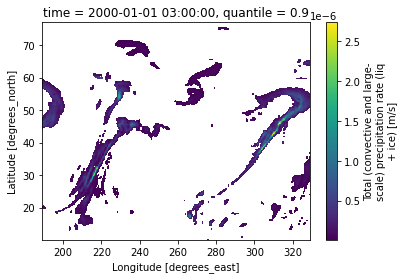

In [72]:
# this step take a long time (reading to memory?)
PEx.isel(time=0).plot()